## Introduction:
The market historical data set of real estate valuation are collected from Sindian Dist., New Taipei City, Taiwan. The real estate valuation is a regression problem.



## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### Pre Processing Libraries

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

#### Model Selection Libraries

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#### Metrics Libraries

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

#### Models Libraries

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR

#### Pipeline Library

In [6]:
from sklearn.pipeline import Pipeline

## Loading Dataset

In [77]:
taiwanre = pd.read_excel('Real estate valuation data set.xlsx', names = ['num','transac_date_floats', 'house_age', 'dist_to_mrt',
                                                                     'near_stores', 'latitude', 'longitude', 
                                                                     'price'])
taiwanre

,num,transac_date_floats,house_age,dist_to_mrt,near_stores,latitude,longitude,price
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.666667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250000,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000000,8.1,104.81010,5,24.96674,121.54067,52.5


In [78]:
taiwanre['transac_date_floats'].value_counts()

2013.416667    58
2013.500000    47
2013.083333    46
2012.916667    38
2013.250000    32
2012.833333    31
2012.666667    30
2013.333333    29
2013.000000    28
2012.750000    27
2013.166667    25
2013.583333    23
Name: transac_date_floats, dtype: int64

We can see that the floats are unique

In [79]:
 taiwanre['transac_date_floats'].value_counts().count()

12

Having exact 12 different floats in a column that is related to dates requires attention

**Inferences:**
- 'transac_date_floats' column in weird. It is displaying invalid dates
- On applying value_counts, we can see that there are lots of common values.
- On chaining .count() method, we can see that there are only 12 unique values. 
- We can infer that this has to do something with the months of an year.

#### Lets isolate the trans_date column and do some cleaning work on it



In [80]:
taiwanre['transac_date_floats'].dtypes

dtype('float64')

In [81]:
taiwanre1 = taiwanre.copy()

In [82]:
taiwanre1['transac_date_floats'].dtypes
taiwanre1['transac_date_floats'] = taiwanre1['transac_date_floats'].astype(str) # converting it to string to use its methods

months = [] # a separate list for extracted month values
for row in taiwanre1['transac_date_floats'].str.split('.'): # getting inside the first layer, and splitting each item right at decimal
    item = row[1] # getting inside the second layer
    item = str('.')+str(row[1]) # to ease up my futher calculation, i am putting a decimal which was lost during split
    item = float(item)  # converting it back to float type
    month = round(item*12 +1) # It was noticed that we had a min month of 0 and max month of 11, so lets add 1
    months.append(month) # throw each result in months basket
years = [] # a separate list for extracted years value

for row in taiwanre['transac_date_floats']: # getting into the column
    item = int(row) # using a side effect of int function that truncates the decimal point rather than rounding off
    years.append(item) # throw each result in years basket
    

In [83]:
date = zip(years,months) # Zipping each month to its year, this created a zip object for me
zipped_date = list(date) # extracting it
print(zipped_date[:5]) # here is the list :) 

[(2012, 12), (2012, 12), (2013, 8), (2013, 7), (2012, 11)]


In [84]:
taiwanre1['transac_date_month'] = months # Making a separate column for months
taiwanre1['transac_date_year'] = years # Making a separate column for years as well


In [85]:
taiwanre1.head(3)

,num,transac_date_floats,house_age,dist_to_mrt,near_stores,latitude,longitude,price,transac_date_month,transac_date_year
0,1,2012.9166667,32.0,84.87882,10,24.98298,121.54024,37.9,12,2012
1,2,2012.9166667,19.5,306.59470,9,24.98034,121.53951,42.2,12,2012
2,3,2013.5833333,13.3,561.98450,5,24.98746,121.54391,47.3,8,2013


In [86]:
list_each_date = [] # a new list to take each tuple converted into list in  zipped_date  
for element in zipped_date:
    element = list(element) # convert each tuple into list
    list_each_date.append(element) # append it into list_each_date
date_list = []
for date in list_each_date:
    date[1] = str(date[1]) # date[1] is the year of each date. converting into string to do modifications
    date[0] = str(date[0]) # date[0] is the month of each date. converting into string to do modifications
    date_list.append(date[1] + '-' + date[0]) # modifying such way that it resembles to date format.

        

In [87]:
taiwanre1['transaction_date'] = date_list
taiwanre1.head(3)

,num,transac_date_floats,house_age,dist_to_mrt,near_stores,latitude,longitude,price,transac_date_month,transac_date_year,transaction_date
0,1,2012.9166667,32.0,84.87882,10,24.98298,121.54024,37.9,12,2012,12-2012
1,2,2012.9166667,19.5,306.59470,9,24.98034,121.53951,42.2,12,2012,12-2012
2,3,2013.5833333,13.3,561.98450,5,24.98746,121.54391,47.3,8,2013,8-2013


In [88]:
taiwanre1 = taiwanre1.drop(['num'], axis=1)
taiwanre1 = taiwanre1.reindex(columns=['transaction_date', 'transac_date_month', 'transac_date_year', 'transac_date_floats',
                          'house_age', 'latitude', 'longitude', 'dist_to_mrt', 'near_stores', 'price'])

In [89]:
taiwanre1.head(3)

,transaction_date,transac_date_month,transac_date_year,transac_date_floats,house_age,latitude,longitude,dist_to_mrt,near_stores,price
0,12-2012,12,2012,2012.9166667,32.0,24.98298,121.54024,84.87882,10,37.9
1,12-2012,12,2012,2012.9166667,19.5,24.98034,121.53951,306.59470,9,42.2
2,8-2013,8,2013,2013.5833333,13.3,24.98746,121.54391,561.98450,5,47.3


In [90]:
taiwanre1['transaction_date'] = taiwanre1['transaction_date'].astype('datetime64[ns]')
taiwanre1['transaction_date'] = taiwanre1['transaction_date'].dt.strftime('%Y-%m')


In [91]:
taiwanre1['transac_date_year'].value_counts()

2013    288
2012    126
Name: transac_date_year, dtype: int64

##### Checking if the dates column does really tell us something significant

In [132]:
taiwanre1['transaction_date'] = pd.to_datetime(taiwanre1['transaction_date'], format='%Y-%M') # Convert into datetime
taiwanre1['transaction_date'] = taiwanre1['transaction_date'].dt.to_period('M') # Just show the time till month


TypeError: Passing PeriodDtype data is invalid. Use `data.to_timestamp()` instead

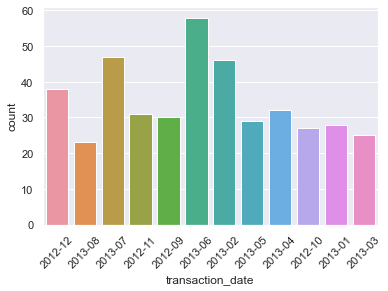

In [173]:
sns.set(style="darkgrid")
sns.countplot(taiwanre1['transaction_date'])
plt.xticks(rotation=45)
plt.show()

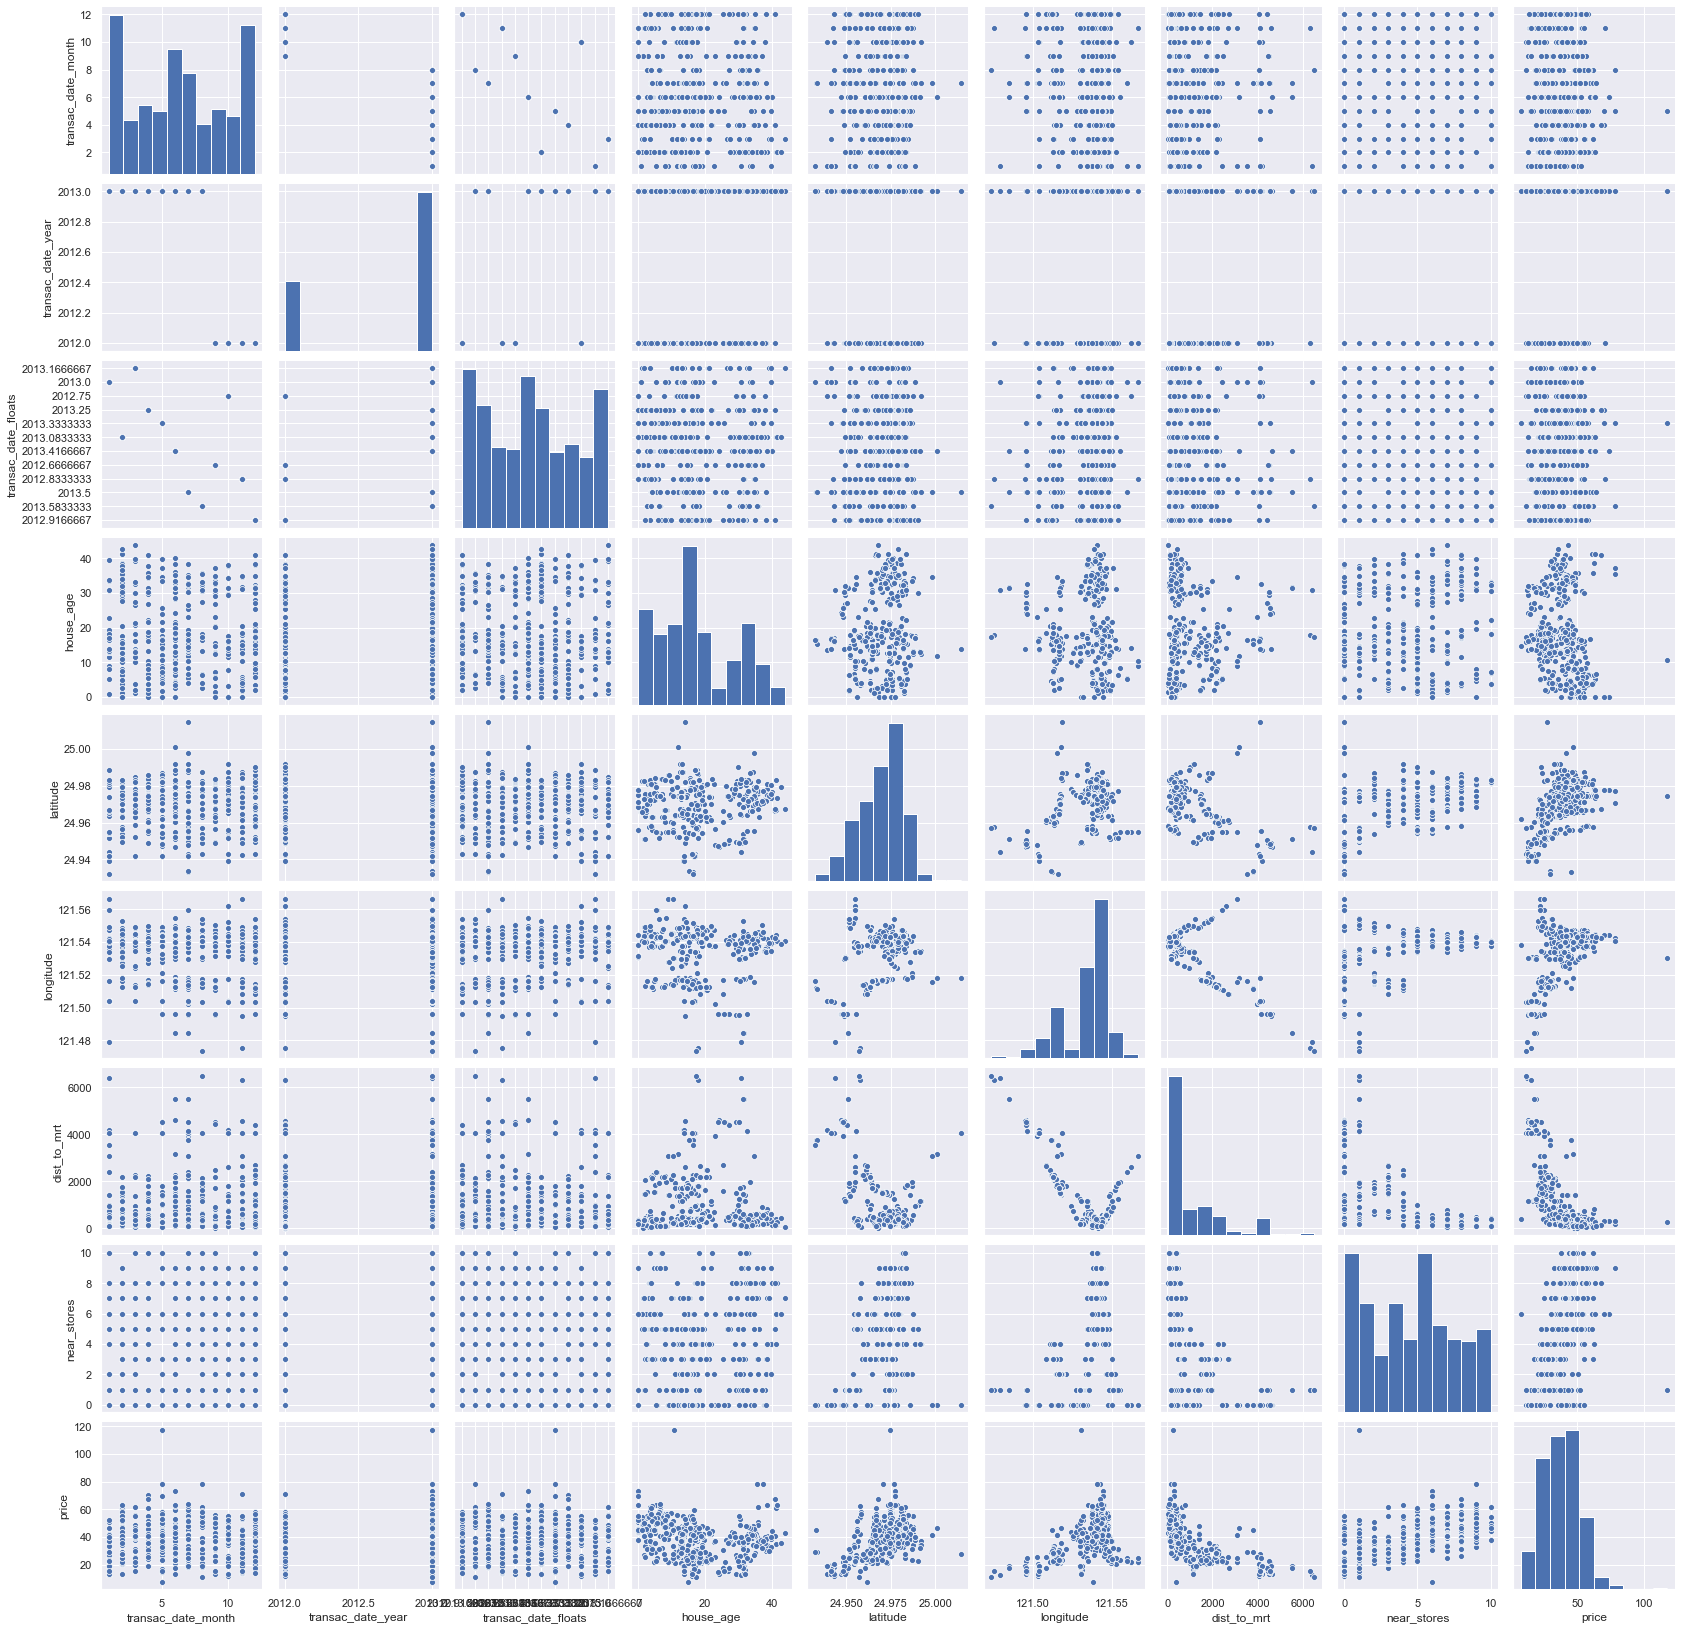

In [135]:
sns.pairplot(taiwanre1)
plt.show()

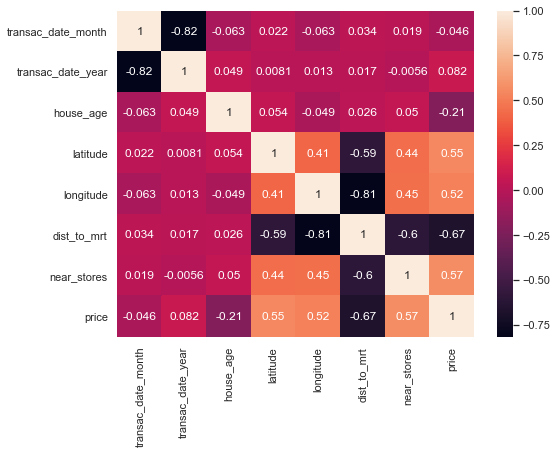

In [136]:
plt.figure(figsize=(8,6))
sns.heatmap(taiwanre1.corr(), annot=True)

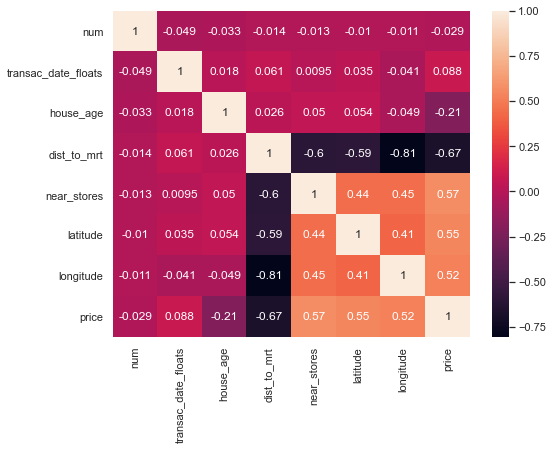

In [138]:
plt.figure(figsize=(8,6))
sns.heatmap(taiwanre.corr(), annot=True)

**Observations**:
- Our features related to the date failed to show any significant correlations with other features


**Conclusion**: 
- We will not consider the date columns, considering the lack of adequate historical data to be the reason behind their insignificant correlations with the rest of data

In [27]:
taiwanre1.columns

Index(['transaction_date', 'transac_date_month', 'transac_date_year',
       'transac_date_floats', 'house_age', 'latitude', 'longitude',
       'dist_to_mrt', 'near_stores', 'price'],
      dtype='object')

In [28]:
taiwanre2 = taiwanre1.drop(['transaction_date', 'transac_date_month', 'transac_date_year','transac_date_floats'], axis=1)

In [29]:
taiwanre2

,house_age,latitude,longitude,dist_to_mrt,near_stores,price
0,32.0,24.98298,121.54024,84.87882,10,37.9
1,19.5,24.98034,121.53951,306.59470,9,42.2
2,13.3,24.98746,121.54391,561.98450,5,47.3
3,13.3,24.98746,121.54391,561.98450,5,54.8
4,5.0,24.97937,121.54245,390.56840,5,43.1
...,...,...,...,...,...,...
409,13.7,24.94155,121.50381,4082.01500,0,15.4
410,5.6,24.97433,121.54310,90.45606,9,50.0
411,18.8,24.97923,121.53986,390.96960,7,40.6
412,8.1,24.96674,121.54067,104.81010,5,52.5


In [30]:
taiwanre2_corr = pd.DataFrame(taiwanre2.corr())

In [31]:
taiwanre2_corr

,house_age,latitude,longitude,dist_to_mrt,near_stores,price
house_age,1.000000,0.054420,-0.048520,0.025622,0.049593,-0.210567
latitude,0.054420,1.000000,0.412924,-0.591067,0.444143,0.546307
longitude,-0.048520,0.412924,1.000000,-0.806317,0.449099,0.523287
dist_to_mrt,0.025622,-0.591067,-0.806317,1.000000,-0.602519,-0.673613
near_stores,0.049593,0.444143,0.449099,-0.602519,1.000000,0.571005
price,-0.210567,0.546307,0.523287,-0.673613,0.571005,1.000000


In [32]:
for row in taiwanre2_corr:
    values = taiwanre2_corr.loc[:, row].sort_values(ascending=False)
    

**Observations:**
- we can see the strong positive correlations between
  - price and near_stores at 0.57
  - price and latitude at 0.546
  - price and longitude at 0.523
- Whereas the strongest negative correlations are between
  - dist_to_mrt and longitude at -0.80
  - price and dist_to_mrt at -0.67
  - near_stores and dist_to_mrt at -0.60

In [33]:
taiwanre3 = taiwanre2.copy()

In [34]:
taiwanre2.head()

,house_age,latitude,longitude,dist_to_mrt,near_stores,price
0,32.0,24.98298,121.54024,84.87882,10,37.9
1,19.5,24.98034,121.53951,306.59470,9,42.2
2,13.3,24.98746,121.54391,561.98450,5,47.3
3,13.3,24.98746,121.54391,561.98450,5,54.8
4,5.0,24.97937,121.54245,390.56840,5,43.1


## Splitting the data into
- Features and Labels
- train and test

In [35]:
# Describing our features and labels
# Features:
X = taiwanre3.drop('price', axis=1).values
# Labels:
y = taiwanre3.loc[:, 'price'].values

print('Features Shape: {}\nLabels Shape: {}'.format(X.shape, y.shape))

Features Shape: (414, 5)
Labels Shape: (414,)


In [36]:
# Splitting the data into training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (331, 5)
X_test shape: (83, 5)
y_train shape: (331,)
y_test shape: (83,)


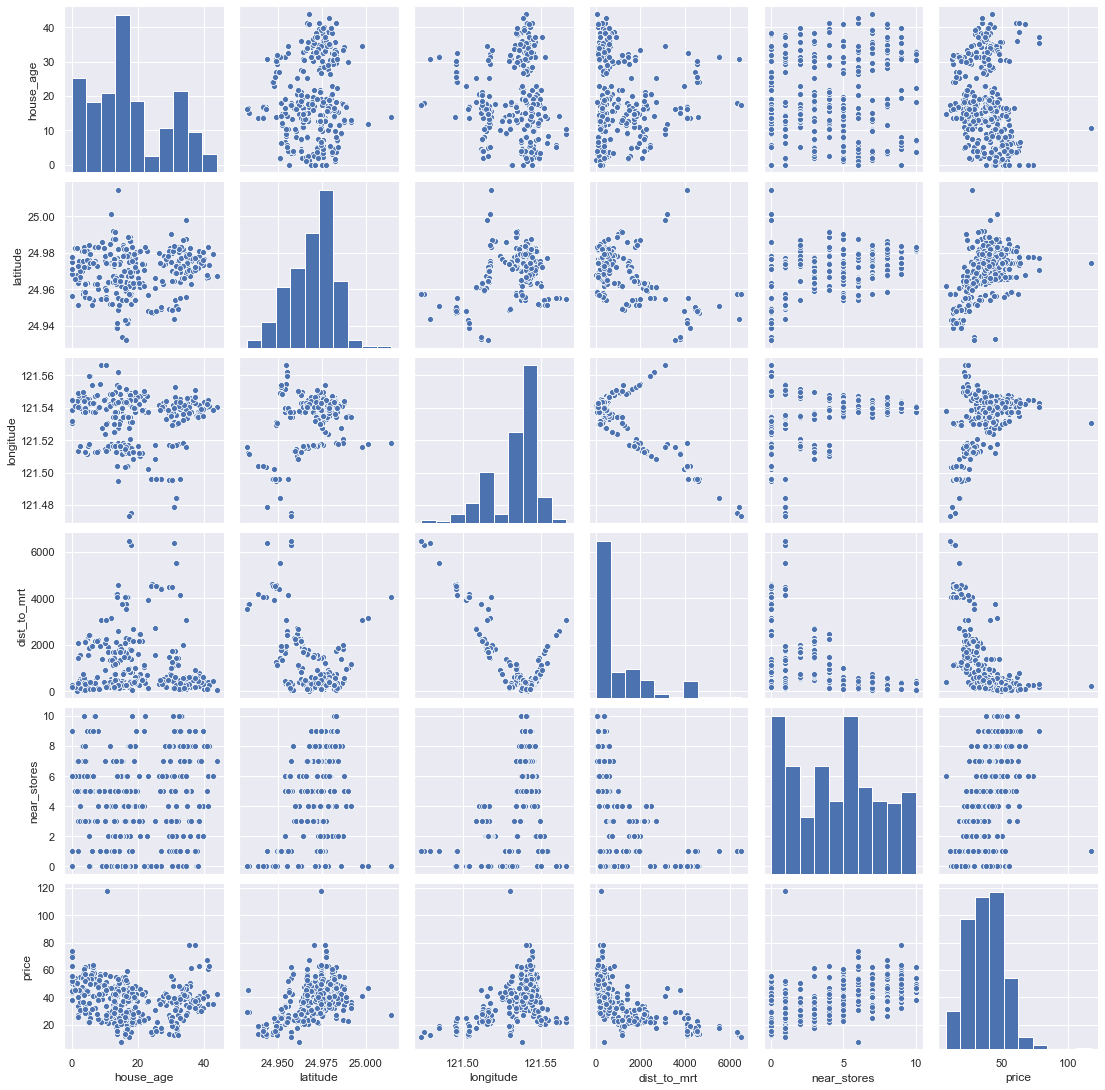

In [37]:
sns.pairplot(taiwanre3)
plt.show()

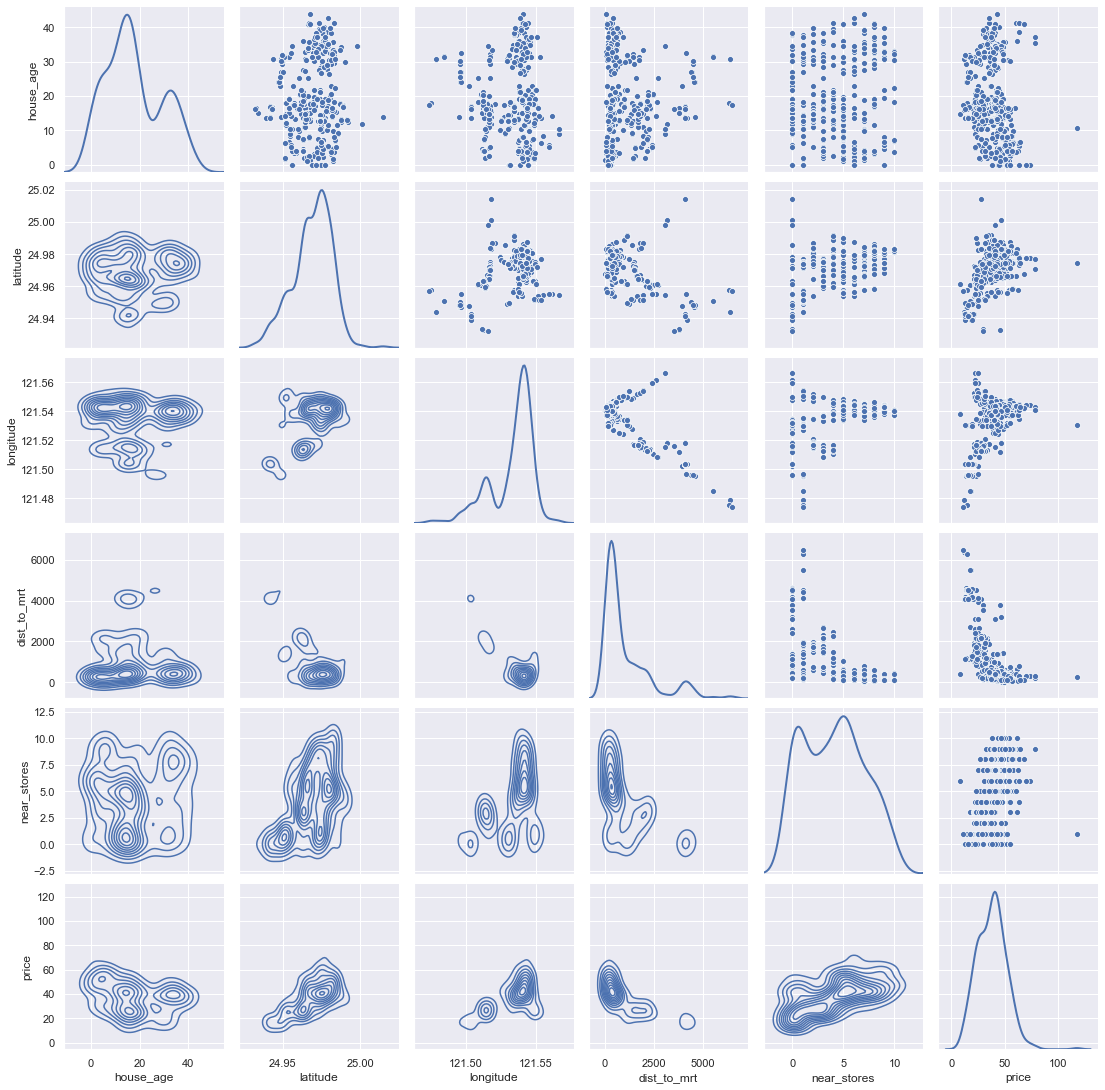

In [38]:
spm = sns.PairGrid(taiwanre3, diag_sharey=False)
spm.map_upper(sns.scatterplot)
spm.map_lower(sns.kdeplot, colors="C0")
spm.map_diag(sns.kdeplot, lw=2)

**Conclusions:**
 - We need to scale our data for Linear Regression
 

### Linear Regression

In [39]:
lr_pipe = Pipeline([('sc', StandardScaler()), ('lr', LinearRegression())])

In [40]:
# Fit the model
lr_pipe.fit(X_train, y_train)

# Predict 
y_pred = lr_pipe.predict(X_test)

# Scores
print('Score on training data: {}\n'.format(lr_pipe.score(X_train, y_train)))
print('Score on test data: {}\n'.format(lr_pipe.score(X_test, y_test)))

Score on training data: 0.5372179466923437

Score on test data: 0.700731455305317



In [41]:
kfold = KFold(n_splits=5, shuffle=True)
print("Cross-validation scores:\n{}".format(cross_val_score(lr_pipe, X, y, cv=kfold)))
print('Mean score = {}'.format(cross_val_score(lr_pipe, X, y, cv=kfold).mean()))


Cross-validation scores:
[0.76616509 0.71315604 0.40946417 0.34875683 0.55936253]
Mean score = 0.56569791300357


In [42]:
# Obtaining the dict of possible parameters
lr_pipe.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('lr', LinearRegression())],
 'verbose': False,
 'sc': StandardScaler(),
 'lr': LinearRegression(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'lr__copy_X': True,
 'lr__fit_intercept': True,
 'lr__n_jobs': None,
 'lr__normalize': False}

In [43]:
# Defining param_grid for LinearRegression
param_grid = {'lr__fit_intercept': [True, False],
              'lr__normalize': [True, False], 
             }

In [44]:
# Setting up grid-search metaestimator
lr_grid = GridSearchCV(lr_pipe, param_grid, cv=5)

# Train the grid-search meta-estimator to find the best model
lr_grid.fit(X_train, y_train)

# Predict
y_pred = lr_grid.predict(X_test)

# Print the Test scores
print('Test Set score with Grid Search:\n{}\n'.format(lr_grid.score(X_test, y_test)))

# Print the best Parameters
print('Best Parameters obtained through GridSearchCV:\n{}\n'.format(lr_grid.best_params_))

# Print The best CV score, Though not required
print('Best CV score obtained through GridSearchCV:\n{}\n'.format(lr_grid.best_score_))


Test Set score with Grid Search:
0.7007314553053171

Best Parameters obtained through GridSearchCV:
{'lr__fit_intercept': True, 'lr__normalize': True}

Best CV score obtained through GridSearchCV:
0.5185351175438405



### Lasso

In [45]:
lasso_pipe = Pipeline([('sc', StandardScaler()), ('lasso', Lasso())])

In [46]:
# Fit the model
lasso_pipe.fit(X_train, y_train)

# Predict 
y_pred = lasso_pipe.predict(X_test)

# Scores
print('Score on training data: {}\n'.format(lasso_pipe.score(X_train, y_train)))
print('Score on test data: {}\n'.format(lasso_pipe.score(X_test, y_test)))

Score on training data: 0.5232943195373685

Score on test data: 0.6781349384525368



In [47]:
kfold = KFold(n_splits=5, shuffle=True)
print("Cross-validation scores:\n{}".format(cross_val_score(lasso_pipe, X, y, cv=kfold)))
print('Mean score = {}'.format(cross_val_score(lasso_pipe, X, y, cv=kfold).mean()))


Cross-validation scores:
[0.58303874 0.44796275 0.42922778 0.62442324 0.67943526]
Mean score = 0.5590178535087331


In [48]:
# Obtaining the dict of possible parameters for Lasso
lasso_pipe.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('lasso', Lasso())],
 'verbose': False,
 'sc': StandardScaler(),
 'lasso': Lasso(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': None,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [49]:
# Defining the parameters for Lasso's Grid Search
param_grid = {'lasso__alpha': [0.01, 0.05, 0.1, 0.25, 0.5, 1],
              'lasso__fit_intercept': [True, False],
              'lasso__max_iter': [100, 200, 500],
              'lasso__normalize': [True, False]
             }


In [50]:
# Setting up grid-search metaestimator
lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=5)

# Train the grid-search meta-estimator to find the best model
lasso_grid.fit(X_train, y_train)

# Predict
y_pred = lasso_grid.predict(X_test)

# Print the Test scores
print('Test Set score with Grid Search:\n{}\n'.format(lasso_grid.score(X_test, y_test)))

# Print the best Parameters
print('Best Parameters obtained through GridSearchCV:\n{}\n'.format(lasso_grid.best_params_))

# Print The best CV score, Though not required
print('Best CV score obtained through GridSearchCV:\n{}\n'.format(lasso_grid.best_score_))


Test Set score with Grid Search:
0.7017851553791704

Best Parameters obtained through GridSearchCV:
{'lasso__alpha': 0.25, 'lasso__fit_intercept': True, 'lasso__max_iter': 100, 'lasso__normalize': False}

Best CV score obtained through GridSearchCV:
0.521023595463545



### Ridge

In [51]:
ridge_pipe = Pipeline([('sc', StandardScaler()), ('ridge', Ridge())])

In [52]:
# Fit the model
ridge_pipe.fit(X_train, y_train)

# Predict 
y_pred = ridge_pipe.predict(X_test)

# Scores
print('Score on training data: {}\n'.format(ridge_pipe.score(X_train, y_train)))
print('Score on test data: {}\n'.format(ridge_pipe.score(X_test, y_test)))

Score on training data: 0.537212228182715

Score on test data: 0.7012080707702977



In [53]:
kfold = KFold(n_splits=5, shuffle=True)
print("Cross-validation scores:\n{}".format(cross_val_score(ridge_pipe, X, y, cv=kfold)))
print('Mean score = {}'.format(cross_val_score(ridge_pipe, X, y, cv=kfold).mean()))


Cross-validation scores:
[0.62956307 0.59682272 0.66239219 0.54926124 0.41485427]
Mean score = 0.5567972814515365


In [54]:
ridge_pipe.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('ridge', Ridge())],
 'verbose': False,
 'sc': StandardScaler(),
 'ridge': Ridge(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In [55]:
# Defining Parameter Grid for Ridge's Grid Search
param_grid = {'ridge__alpha':[0.01, 0.1, 0.25, 0.5, 1.0], 
              'ridge__fit_intercept':[True, False],
              'ridge__normalize':[True, False],
              'ridge__solver':['auto', 'svd', 'cholesky', 'lsqr']
              }

In [56]:
# Setting up grid-search metaestimator
ridge_grid = GridSearchCV(ridge_pipe, param_grid, cv=5)

# Train the grid-search meta-estimator to find the best model
ridge_grid.fit(X_train, y_train)

# Predict
y_pred = ridge_grid.predict(X_test)

# Print the Test scores
print('Test Set score with Grid Search:\n{}\n'.format(ridge_grid.score(X_test, y_test)))

# Print the best Parameters
print('Best Parameters obtained through GridSearchCV:\n{}\n'.format(ridge_grid.best_params_))

# Print The best CV score, Though not required
print('Best CV score obtained through GridSearchCV:\n{}\n'.format(ridge_grid.best_score_))


Test Set score with Grid Search:
0.70534921754225

Best Parameters obtained through GridSearchCV:
{'ridge__alpha': 0.1, 'ridge__fit_intercept': True, 'ridge__normalize': True, 'ridge__solver': 'lsqr'}

Best CV score obtained through GridSearchCV:
0.5202366148832429



### KNeighborsRegressor

In [57]:
knn_pipe = Pipeline([('rs', RobustScaler()), ('knn', KNeighborsRegressor())])

In [58]:
# Fit the model
knn_pipe.fit(X_train, y_train)

# Predict 
y_pred = knn_pipe.predict(X_test)

# Scores
print('Score on training data: {}\n'.format(knn_pipe.score(X_train, y_train)))
print('Score on test data: {}\n'.format(knn_pipe.score(X_test, y_test)))

Score on training data: 0.7576497823885393

Score on test data: 0.7025538421825374



In [59]:
kfold = KFold(n_splits=5, shuffle=True)
print("Cross-validation scores:\n{}".format(cross_val_score(knn_pipe, X, y, cv=kfold)))
print('Mean score = {}'.format(cross_val_score(knn_pipe, X, y, cv=kfold).mean()))


Cross-validation scores:
[0.65584794 0.765376   0.32214123 0.8254585  0.70581737]
Mean score = 0.6652707911443576


In [60]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('rs', RobustScaler()), ('knn', KNeighborsRegressor())],
 'verbose': False,
 'rs': RobustScaler(),
 'knn': KNeighborsRegressor(),
 'rs__copy': True,
 'rs__quantile_range': (25.0, 75.0),
 'rs__with_centering': True,
 'rs__with_scaling': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [61]:
# Setting up Grid-Search parameters
param_grid = {'knn__algorithm': ['auto','brute'],
              'knn__leaf_size': [5, 10, 12, 15],
              'knn__n_neighbors': [3, 5, 7, 10],
              'knn__weights': ['uniform','distance']
             }

In [62]:
# Setting up grid-search metaestimator
knn_grid = GridSearchCV(knn_pipe, param_grid, cv=5)

# Train the grid-search meta-estimator to find the best model
knn_grid.fit(X_train, y_train)

# Predict
y_pred = knn_grid.predict(X_test)

# Print the Test scores
print('Test Set score with Grid Search:\n{}\n'.format(knn_grid.score(X_test, y_test)))

# Print the best Parameters
print('Best Parameters obtained through GridSearchCV:\n{}\n'.format(knn_grid.best_params_))

# Print The best CV score, Though not required
print('Best CV score obtained through GridSearchCV:\n{}\n'.format(knn_grid.best_score_))


Test Set score with Grid Search:
0.7800927127473847

Best Parameters obtained through GridSearchCV:
{'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Best CV score obtained through GridSearchCV:
0.6647622805177877



### DecisionTreeRegressor

In [63]:
# Instantiate the model
tree = DecisionTreeRegressor()

# Fit the model
tree.fit(X_train, y_train)

# Scores
print('Score on training data: {}\n'.format(tree.score(X_train, y_train)))
print('Score on test data: {}\n'.format(tree.score(X_test, y_test)))

Score on training data: 0.9908602573152887

Score on test data: 0.5658267882463



**Obervations**:
- Near perfect training score and a testing score of 0.56 hints towards OverFitting 

In [64]:
kfold = KFold(n_splits=5)
print("Cross-validation scores:\n{}".format(cross_val_score(tree, X, y, cv=kfold)))

Cross-validation scores:
[ 0.51379386 -0.09877412  0.59505731  0.52903195  0.19409027]


In [65]:
# Get parameters for DecisionTreeRegressor
tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [66]:
# Setting up param_geid for DecisionTreeRegressor
param_grid = {'criterion': ['mse', 'mae'],
              'min_samples_split': [10, 20, 40],
              'max_depth': [2, 6, 8],
              'min_samples_leaf': [20, 40, 100],
              'max_leaf_nodes': [5, 20, 100],
              }

In [67]:
# Instantiate the model
tree = DecisionTreeRegressor()

# Setting up grid-search metaestimator
tree_gscv = GridSearchCV(tree, param_grid, cv=5)

# Train the grid-search meta-estimator to find the best model
tree_gscv.fit(X_train, y_train)

# Print the Test scores
print('Test Set score with Grid Search:\n{}\n'.format(tree_gscv.score(X_test, y_test)))

# Print the best Parameters
print('Best Parameters obtained through GridSearchCV:\n{}\n'.format(tree_gscv.best_params_))

# Print The best CV score, Though not required
print('Best CV score obtained through GridSearchCV:\n{}\n'.format(tree_gscv.best_score_))


Test Set score with Grid Search:
0.7918533066172971

Best Parameters obtained through GridSearchCV:
{'criterion': 'mae', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 10}

Best CV score obtained through GridSearchCV:
0.6023014365362065



### RandomForestRegressor

In [68]:
# Instatiate the model
rf = RandomForestRegressor()

# Fit the model
rf.fit(X_train, y_train)

# Scores
print('Score on training data: {}\n'.format(rf.score(X_train, y_train)))
print('Score on test data: {}\n'.format(rf.score(X_test, y_test)))

Score on training data: 0.9450931636158761

Score on test data: 0.5889290337646154



**Observation:**
- Again, the model is overfitting 

In [69]:
kfold = KFold(n_splits=5)
print("Cross-validation scores:\n{}".format(cross_val_score(rf, X, y, cv=kfold)))

Cross-validation scores:
[0.73650457 0.69002418 0.72930967 0.53153347 0.71526467]


In [70]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [71]:
# Set up parameters for GridSearch with RandomForest
param_grid = {'criterion': ['mse', 'mae'],
              'n_estimators': [10,20,50],
              'max_features': ['auto', 'sqrt'],
              'bootstrap': [True, False],
              'max_depth': [2, 6, 8],
              'max_leaf_nodes': [5, 20, 100],
        }

In [72]:
# Instantiate the model
rf = RandomForestRegressor()

# Setting up grid-search metaestimator
rf_gscv = GridSearchCV(rf, param_grid, cv=5)

# Train the grid-search meta-estimator to find the best model
rf_gscv.fit(X_train, y_train)

# Print the Test scores
print('Test Set score with Grid Search:\n{}\n'.format(rf_gscv.score(X_test, y_test)))

# Print the best Parameters
print('Best Parameters obtained through GridSearchCV:\n{}\n'.format(rf_gscv.best_params_))

# Print The best CV score, Though not required
print('Best CV score obtained through GridSearchCV:\n{}\n'.format(rf_gscv.best_score_))

Test Set score with Grid Search:
0.2151473941585339

Best Parameters obtained through GridSearchCV:
{'bootstrap': False, 'criterion': 'mse', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': 100, 'n_estimators': 50}

Best CV score obtained through GridSearchCV:
0.6932640451484365



## Lets move on with DecisionTreeRegressor model and look a bit further into it

In [73]:
from sklearn.metrics.scorer import SCORERS
SCORERS.keys()

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

### Finding Negative Mean Squared Error

In [74]:
tree = DecisionTreeRegressor(random_state=0)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

mse_pred = mean_squared_error(y_test, y_pred)
print(mse_pred)

67.08565505354753


In [75]:
param_grid = {'criterion': ['mse', 'mae'],
              'min_samples_split': [10, 20, 40],
              'max_depth': [2, 6, 8],
              'min_samples_leaf': [20, 40, 100],
              'max_leaf_nodes': [5, 20, 100],
              }

tree = DecisionTreeRegressor()

# Setting up grid-search metaestimator
tree_gscv = GridSearchCV(tree, param_grid, cv=5, scoring=('neg_mean_squared_error'))

# Train the grid-search meta-estimator to find the best model
tree_gscv.fit(X_train, y_train)

# Print the Neg Mean Squared Error
print('Neg Mean Squared Error with Grid Search:\n{}\n'.format(tree_gscv.score(X_test, y_test)))

# Print the best Parameters
print('Best Parameters obtained through GridSearchCV:\n{}\n'.format(tree_gscv.best_params_))

# Print The best CV nmse, Though not required
print('Best CV NMSE obtained through GridSearchCV:\n{}\n'.format(tree_gscv.best_score_))


Neg Mean Squared Error with Grid Search:
-31.593765060240962

Best Parameters obtained through GridSearchCV:
{'criterion': 'mae', 'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 40}

Best CV NMSE obtained through GridSearchCV:
-76.58069889190412



In [76]:
tree_grid_results = pd.DataFrame(tree_gscv.cv_results_)
tree_grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0,0.0,0.000000,0.000000,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",-158.140896,-59.631452,-85.002312,-77.270551,-73.444990,-90.698040,34.710454,102
1,0.0,0.0,0.000000,0.000000,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",-158.140896,-59.631452,-85.002312,-77.270551,-73.444990,-90.698040,34.710454,102
2,0.0,0.0,0.000000,0.000000,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",-158.140896,-59.631452,-85.002312,-77.270551,-73.444990,-90.698040,34.710454,106
3,0.0,0.0,0.000000,0.000000,mse,2,5,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",-154.357786,-59.104220,-82.747961,-73.532025,-80.281831,-90.004765,33.210549,95
4,0.0,0.0,0.001599,0.003198,mse,2,5,40,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",-154.357786,-59.104220,-82.747961,-73.532025,-80.281831,-90.004765,33.210549,95
